# 📁 Projet final – Data Crafting & Data Mining

Ce projet vous permettra de mettre en œuvre tout le cycle de traitement de données :
- Qualité et structuration (Data Crafting)
- Exploration, préparation et modélisation (Data Mining)

**Domaine :** Gestion des ressources humaines (1200 employés)

**Choix de modélisation :** 2 modélisations possibles à la partie 5. Faites votre choix et poursuivez le projet
- Classification : Construire un modèle prédictif du type de contrat et Évaluer la précision sur les nouveaux employés
- Clustering : Identifier naturellement des profils d’employés et Interpréter les groupes pour recommandations RH

**Fichier de données :** `dataset_rh.csv`

📅 Délai de rendu : 1 semaine après la fin du module.

##  Partie 1 – Chargement & exploration initiale

In [124]:
import great_expectations as ge
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Charger le dataset
df = pd.read_csv("dataset_rh.csv")

# TODO : Afficher les 5 premières lignes et les dimensions du dataset
# ...
print(df.shape)
df.head()

(1200, 11)


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaN
2,EMP00002,Blondel,Catherine,53,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04


##  Partie 2 – nettoyage, alignement, validation puis pipeline

In [125]:
# exploration rapide pour recuperer les valeurs uniques des colonnes categorielle
cols_categorielle = ["Sexe", "TypeContrat", "NiveauEtude", "Departement"]
for col in cols_categorielle:
    print(f"{col}: {df[col].unique()}")

Sexe: ['F' 'H' nan 'Autre']
TypeContrat: ['Stage' 'CDI' 'Alternance' 'CDD' nan]
NiveauEtude: ['Bac+3' 'Master' 'Bac+2' nan 'Bac' 'Doctorat']
Departement: ['Marketing' 'Production' 'Informatique' 'Logistique' 'RH' 'Finance']


In [126]:
# TODO :
# - Identifier les colonnes avec des valeurs manquantes ou corrompues
# - Corriger les âges aberrants, les salaires négatifs
# - Nettoyer les dates incorrectes (ex: "Non précisé") et convertir les dates valides
# - Supprimer ou corriger les doublons éventuels
# - Nettoyer les formats (genre, contrat, niveau d'études)
# - Utiliser great Expectations pour la validation
# - Créer un pipeline complet de cette première étape

# Identifier les colonnes avec des valeurs manquantes ou corrompues
print(df.isnull())

def correct_age(df):
    # Corriger les âges aberrants en mettant la mediane des âges valides si l'âge est en dehors de 18-65
    median_age = df["Age"].median()
    df["Age"] = df["Age"].apply(lambda x: median_age if x < 18 or x > 65 else x)
    return df

def correct_salary(df):
    # Corriger les salaires négatifs en mettant la mediane des salaires valides
    median_salary = df["Salaire"].median()
    df["Salaire"] = df["Salaire"].apply(lambda x: median_salary if x < 0 else x)
    return df

def clean_dates(df):
    # Nettoyer les dates incorrectes et convertir les dates valides
    df["DateEmbauche"] = pd.to_datetime(df["DateEmbauche"], errors="coerce")
    df["DateEmbauche"].fillna(df["DateEmbauche"].median(), inplace=True)
    return df

def remove_duplicates(df):
    # Supprimer les doublons éventuels
    df = df.drop_duplicates()
    return df

def clean_formats(df):
    # Nettoyer les formats (genre, contrat, niveau d'études)
    df["Sexe"] = df["Sexe"].str.strip().str.capitalize()
    # we might have values outside of H or F, if so, we can set them to 'A'
    df["Sexe"] = df["Sexe"].apply(lambda x: x if x in ["H", "F"] else "A")
    df["TypeContrat"] = df["TypeContrat"].apply(
        lambda x: x if x in ["CDI", "CDD", "Stage", "Alternance"] else "AUTRE"
    )
    df["TypeContrat"] = df["TypeContrat"].str.strip().str.upper()
    df["NiveauEtude"] = df["NiveauEtude"].apply(
        lambda x: (
            x if x in ["Bac", "Bac+2", "Bac+3", "Master", "Doctorat"] else "Inconnu"
        )
    )
    df["NiveauEtude"] = df["NiveauEtude"].str.strip().str.capitalize()
    return df


def validate_with_great_expectations(df, verbose=True):
    # EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
    context = ge.get_context(mode="ephemeral")
    datasource = context.data_sources.add_pandas("pandas_datasource")
    data_asset = datasource.add_dataframe_asset(name="rh_data")
    batch_definition = data_asset.add_batch_definition_whole_dataframe("batch_def")

    # --- Définition du suite d'expectations ---
    expectations = ge.ExpectationSuite(name="rh_validation_suite")

    # EmployeID
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="EmployeID")
    )
    # Nom et Prenom
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="Nom")
    )
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="Prenom")
    )
    # Sexe
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="Sexe")
    )
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToBeInSet(
            column="Sexe", value_set=["H", "F", "A"]
        )
    )
    # Departement
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="Departement")
    )
    # Poste
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="Poste")
    )
    # Salaire
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="Salaire")
    )
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToBeBetween(column="Salaire", min_value=0)
    )
    # NiveauEtude
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="NiveauEtude")
    )
    # TypeContrat
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="TypeContrat")
    )
    # DateEmbauche
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToNotBeNull(column="DateEmbauche")
    )
    expectations.add_expectation(
        ge.expectations.ExpectColumnValuesToBeOfType(
            column="DateEmbauche", type_="datetime64[ns]"
        )
    )

    # On enregistre le suite dans le contexte
    expectations = context.suites.add(expectations)

    validation_definition = ge.ValidationDefinition(
        name="rh_validation_definition",
        data=batch_definition,
        suite=expectations,
    )
    validation_definition = context.validation_definitions.add(validation_definition)

    results = validation_definition.run(batch_parameters={"dataframe": df})
    isallsuccess = results.success
    if verbose:
        print(f"\n  Validation réussie: {results.success}")
        print(f"  Nombre de tests: {len(results.results)}")
    for result in results.results:
        status = "OK" if result.success else "ECHEC"
        if verbose and (not result.success):
            print(f"    [{status}] {result.expectation_config.type} on {result.expectation_config.kwargs}")

    if not isallsuccess:
        raise ValueError("La validation des données a échoué.")
    return df


def enrichissement_pipeline(df):
    df["AnneeEmbauche"] = df["DateEmbauche"].dt.year
    return df


def data_cleaning_pipeline(df):
    df = correct_age(df)
    df = correct_salary(df)
    df = clean_dates(df)
    df = remove_duplicates(df)
    df = clean_formats(df)
    df = validate_with_great_expectations(df, verbose=False)
    df = enrichissement_pipeline(df)
    return df

      EmployeID    Nom  Prenom    Age   Sexe  Departement  Poste  Salaire  \
0         False  False   False  False  False        False  False    False   
1         False  False   False  False  False        False  False    False   
2         False  False   False  False  False        False  False    False   
3         False  False   False  False  False        False  False    False   
4         False  False   False  False  False        False  False    False   
...         ...    ...     ...    ...    ...          ...    ...      ...   
1195      False  False   False  False  False        False  False    False   
1196      False  False   False  False  False        False  False    False   
1197      False  False   False  False  False        False  False    False   
1198      False  False   False  False  False        False  False    False   
1199      False  False   False  False  False        False  False    False   

      NiveauEtude  TypeContrat  DateEmbauche  
0           False        Fal

## Partie 3 – Construction du pipeline de transformation

In [127]:
# TODO :
# - Utiliser le pipeline précédent pour créer un DataFrame nettoyé
# - Encodage des colonnes catégorielles
# - Normalisation éventuelle de variables numériques
# - Vérification finale de la complétude
# - créer un pipeline final = pipeline nettayage + pipeline transformation
df = data_cleaning_pipeline(df)

def encode_and_normalize(df):
    # Encodage des colonnes catégorielles avec one-hot encoding (on garde les colonnes de base)
    df["Departement_og"] = df["Departement"]
    df = pd.get_dummies(df, columns=["Sexe", "Departement", "Poste", "NiveauEtude", "TypeContrat"], drop_first=True, prefix_sep="_")

    # Normalisation des variables numériques
    scaler = MinMaxScaler()
    df[["Age_normalized", "Salaire_normalized"]] = scaler.fit_transform(df[["Age", "Salaire"]])

    return df

df_normalized = encode_and_normalize(df)
df_normalized.head()

C:\Users\guill\AppData\Local\Temp\ipykernel_6732\1292719957.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["DateEmbauche"].fillna(df["DateEmbauche"].median(), inplace=True)
Calculating Metrics: 100%|██████████| 68/68 [00:00<00:00, 6156.51it/s]


,EmployeID,Nom,Prenom,Age,Salaire,DateEmbauche,AnneeEmbauche,Departement_og,Sexe_F,Sexe_H,...,NiveauEtude_Bac+3,NiveauEtude_Doctorat,NiveauEtude_Inconnu,NiveauEtude_Master,TypeContrat_AUTRE,TypeContrat_CDD,TypeContrat_CDI,TypeContrat_STAGE,Age_normalized,Salaire_normalized
0,EMP00000,Dijoux,Zacharie,36.0,21649.44,2017-03-17,2017,Marketing,True,False,...,True,False,False,False,False,False,False,True,0.391304,0.282091
1,EMP00001,Philippe,Théophile,64.0,22127.03,2020-12-26,2020,Marketing,False,True,...,True,False,False,False,False,False,True,False,1.000000,0.290746
2,EMP00002,Blondel,Catherine,53.0,26105.59,2023-05-02,2023,Production,False,True,...,True,False,False,False,False,False,False,False,0.760870,0.362851
3,EMP00003,Berthelot,Maryse,47.0,29066.15,2016-03-24,2016,Marketing,False,True,...,False,False,False,True,False,True,False,False,0.630435,0.416507
4,EMP00004,Clément,Christelle,25.0,34440.50,2016-09-04,2016,Informatique,True,False,...,False,False,False,False,False,False,True,False,0.152174,0.513909


## Partie 4 – Exploration statistique

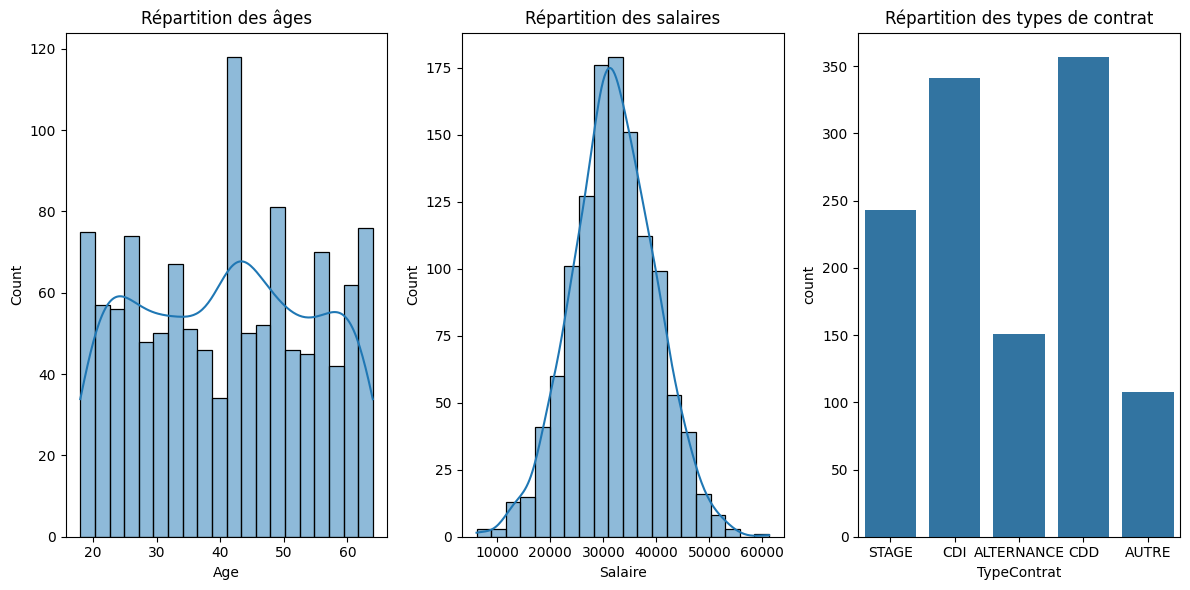

In [128]:
# TODO :
# - Visualiser la répartition des âges, salaires, types de contrat
# - Identifier des corrélations ou anomalies intéressantes
# - Produire des graphiques utiles à l'analyse RH

def visualise(df):
    # Visualiser la répartition des âges, salaires, types de contrat
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(df["Age"], bins=20, kde=True)
    plt.title("Répartition des âges")
    plt.subplot(1, 3, 2)
    sns.histplot(df["Salaire"], bins=20, kde=True)
    plt.title("Répartition des salaires")
    plt.subplot(1, 3, 3)
    sns.countplot(x="TypeContrat", data=df)
    plt.title("Répartition des types de contrat")
    plt.tight_layout()
    plt.show()

visualise(df)


## Partie 5 – Modélisation (clustering ou classification)
Pour la suite du projet vous êtes libres de choisir entre les 2 problèmes:
- Classification : Construire un modèle prédictif du type de contrat et Évaluer la précision sur les nouveaux employés
- Clustering : Identifier naturellement des profils d’employés et Interpréter les groupes pour recommandations RH

Features utilisées pour le clustering: ['Age_normalized', 'Salaire_normalized']
Silhouette score for k=2: 0.4937
Silhouette score for k=3: 0.4081
Silhouette score for k=4: 0.3701
Silhouette score for k=5: 0.3641
Silhouette score for k=6: 0.3623
Silhouette score for k=7: 0.3391
Silhouette score for k=8: 0.3339
Silhouette score for k=9: 0.3408
Silhouette score for k=10: 0.3392
Silhouette score for k=11: 0.3480
Silhouette score for k=12: 0.3487
Silhouette score for k=13: 0.3430
Silhouette score for k=14: 0.3409
Silhouette score for k=15: 0.3384
Silhouette score for k=16: 0.3390
Silhouette score for k=17: 0.3431
Silhouette score for k=18: 0.3372
Silhouette score for k=19: 0.3383
Nombre optimal de clusters: 2


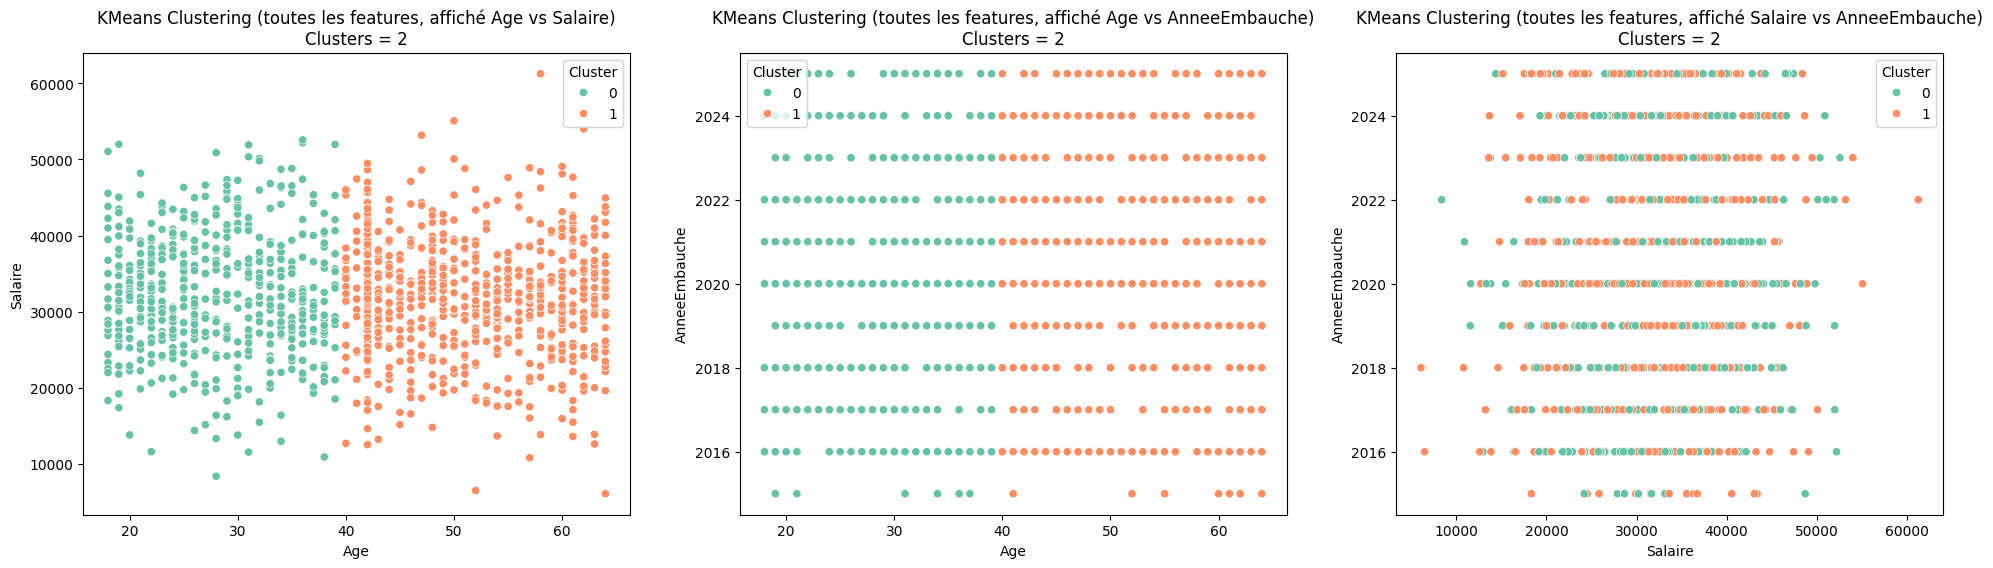

In [129]:
# TODO :
# - Appliquer un algorithme de ML (KMeans, LogisticRegression, DecisionTree…)
# - Évaluer les résultats obtenus (visualisation ou métriques)

# Objectif : regrouper les employ ́es en profils homog`enes
# Exemples d’interpr ́etations :
# Junior / Senior
# Technique / Commercial / Support
# Haut salaire / Bas salaire
# Valeur m ́etier : segmentation RH pour recrutement, formation et
# r ́etention.
# David A. Ouedraogo, Senior Data Scientist / AI Engineer, Formateur Data Scientist / IA G ́en ́erative —
# Projet — Donn ́ees RH — ESIEA 8 / 9


def calculate_optimal_k(X, verbose=True):
    """
    Using silhouette score to find the optimal number of clusters
    X: numpy array or dataframe with only the features used for clustering
    """
    silhouette_scores = []
    K = range(2, 20)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        if verbose:
            print(f"Silhouette score for k={k}: {score:.4f}")

    optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
    return optimal_k


def apply_kmeans(df, verbose=True):
    """
    Apply KMeans clustering on ALL numeric columns of the normalized dataframe
    (except IDs / names / dates)
    """
    df = df.copy() # découpler le dataframe d'origine
    # 1) Select numeric columns only
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # 2) Remove columns that should NOT be used for clustering
    cols_to_exclude = [
        "EmployeID",
        "AnneeEmbauche",
        "Department_og", # we keep original department for analysis
        "Age", # we use normalized age
        "Salaire", # we use normalized salary
    ]  # add others if numeric (e.g. indexes)
    features = [col for col in numeric_cols if col not in cols_to_exclude]
    if verbose:
        print(f"Features utilisées pour le clustering: {features}")
    X = df[features]

    # 3) Calculate optimal number of clusters on all features
    optimal_k = calculate_optimal_k(X, verbose=verbose)
    if verbose:
        print(f"Nombre optimal de clusters: {optimal_k}")

    # 4) Fit KMeans on all selected features
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df["Cluster"] = kmeans.fit_predict(X)

    # 5) Visualize clusters (multiple plot)
    # age vs salaire
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 3, 1)
    sns.scatterplot(x="Age", y="Salaire", hue="Cluster", data=df, palette="Set2")
    plt.title(
        f"KMeans Clustering (toutes les features, affiché Age vs Salaire)\nClusters = {optimal_k}"
    )
    # age vs AnneeEmbauche
    plt.subplot(1, 3, 2)
    sns.scatterplot(x="Age", y="AnneeEmbauche", hue="Cluster", data=df, palette="Set2")
    plt.title(
        f"KMeans Clustering (toutes les features, affiché Age vs AnneeEmbauche)\nClusters = {optimal_k}"
    )
    # salaire vs AnneeEmbauche
    plt.subplot(1, 3, 3)
    sns.scatterplot(x="Salaire", y="AnneeEmbauche", hue="Cluster", data=df, palette="Set2")
    plt.title(
        f"KMeans Clustering (toutes les features, affiché Salaire vs AnneeEmbauche)\nClusters = {optimal_k}"
    )
    plt.show()

    return df


df_clustered = apply_kmeans(df_normalized)


--- Département: Marketing ---


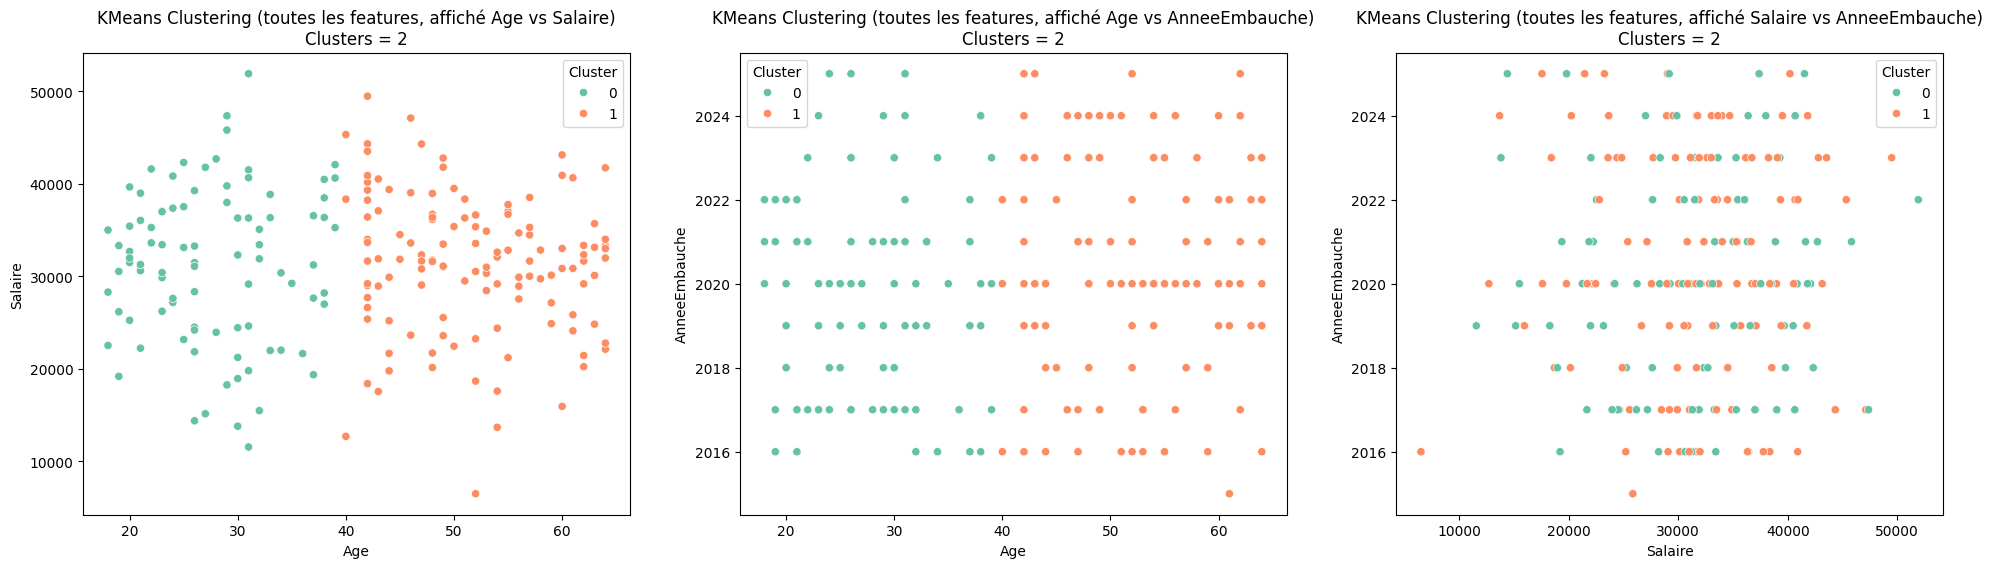


--- Département: Production ---


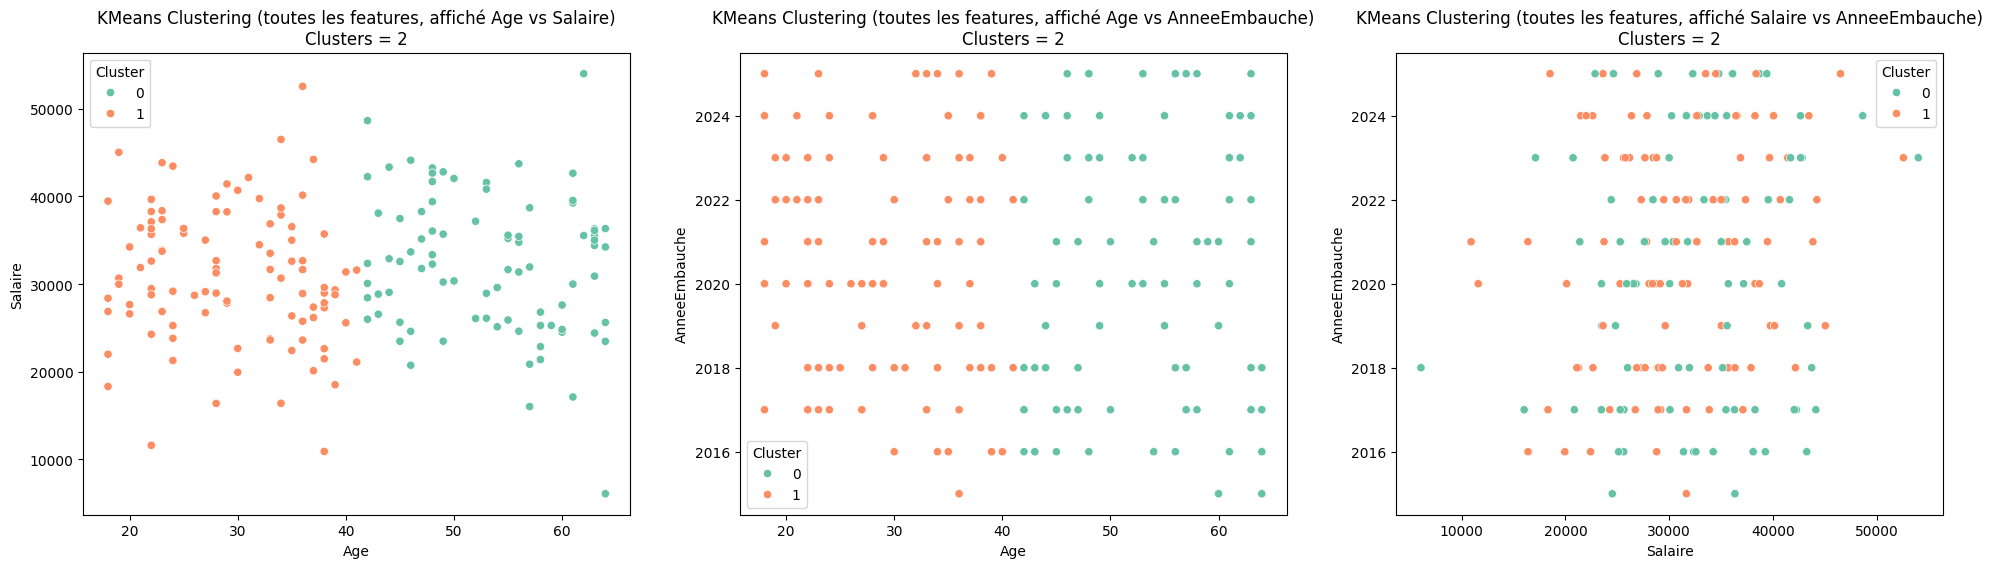


--- Département: Informatique ---


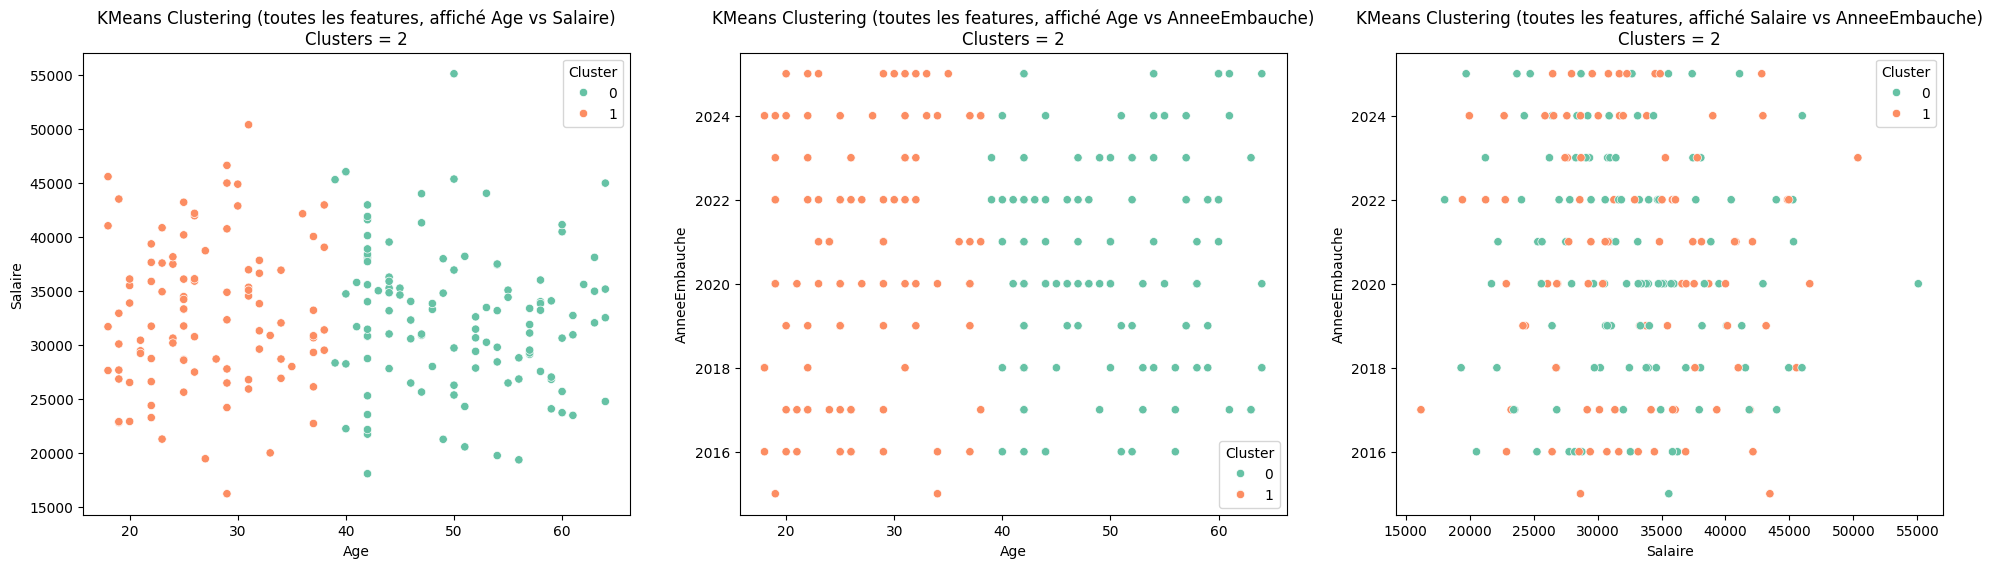


--- Département: Logistique ---


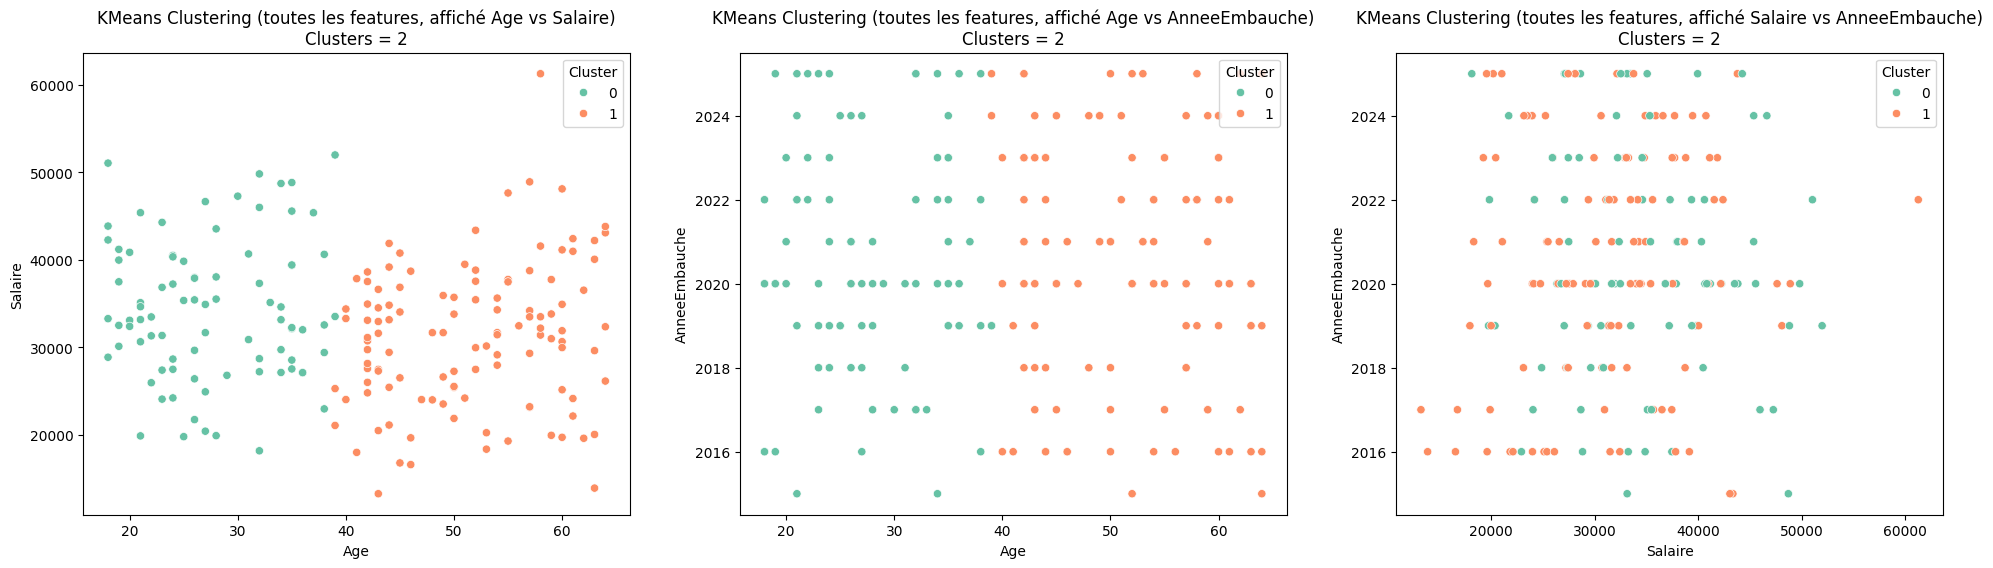


--- Département: RH ---


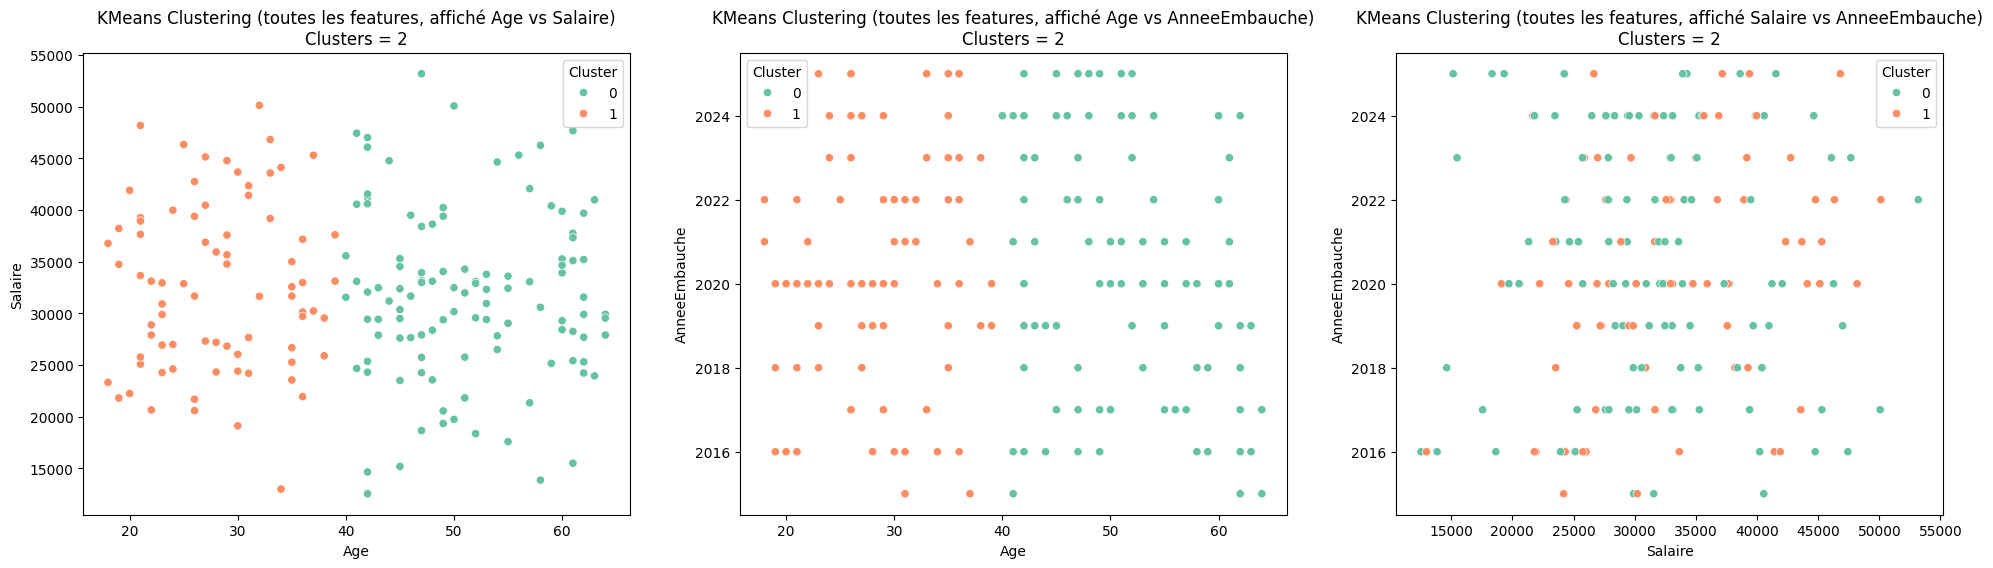


--- Département: Finance ---


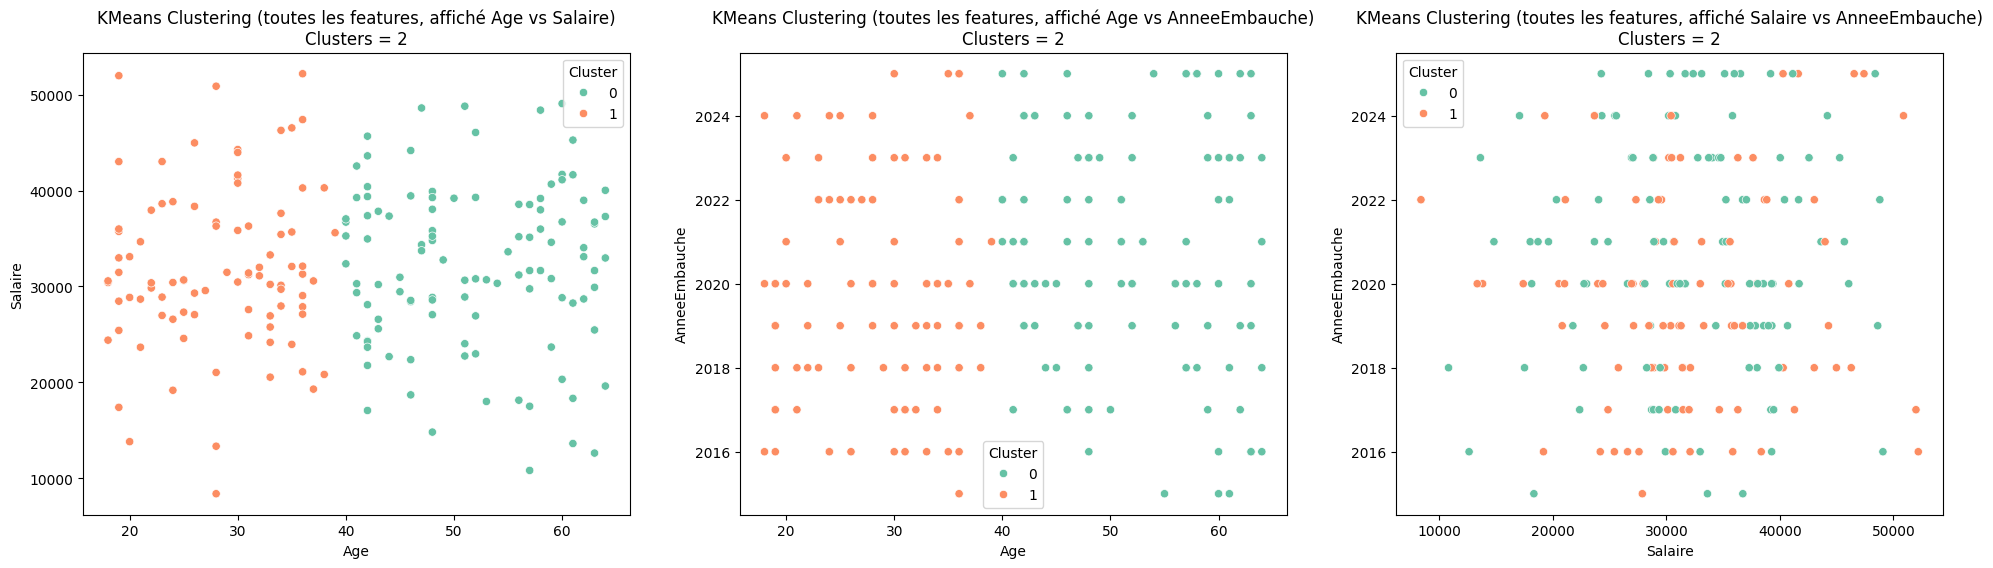

In [130]:
# juste par curiosité, appliquer KMeans par département

def apply_kmeans_by_department(df, verbose=True):
    # for each unique department, apply kmeans
    departments = df["Departement_og"].unique()
    df_list = []
    for dept in departments:
        df_dept = df[df["Departement_og"] == dept].copy()
        print(f"\n--- Département: {dept} ---")
        df_dept_clustered = apply_kmeans(df_dept, verbose=verbose)
        df_list.append(df_dept_clustered)
    df_final = pd.concat(df_list, ignore_index=True)
    return df_final
df_clustered_by_dept = apply_kmeans_by_department(df_normalized, verbose=False)

## Partie 6 – Conclusion et recommandations

In [ ]:
# TODO :
# - Synthétiser les problèmes détectés et les corrections apportées
# - Présenter une recommandation métier à partir des résultats

# actuellement les données ne sont pas assez "bonnes" pour faire du clustering pertinent
# il faudrait plus de données, et des données plus variées (plus de colonnes)
# par exemple des données sur la performance, la satisfaction, les compétences, date de récupération des données